## Create Training Files


In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import glob
import os
import os.path
import time
import requests
import pickle
import shutil
import subprocess
import matplotlib.pyplot as plt
import numpy as np
import glob
import random
from pathlib import Path
from bs4 import BeautifulSoup as bsoup

from utils import *
from extract_bootleg import *

## 0. Create `score_feat` directory


Before starting we need to do the following:

1. Download the PDF sheet music scores from IMSLP
2. Convert PDFs to PNG images
3. Extract bootleg scores for each image and save in `score_feat`.


In [2]:
def download_file(local_filename, download_link, username, password):
    """
    Logs into IMSLP and downloads a single file.
    """
    time.sleep(1)
    login_url = (
        "https://imslp.org/index.php?title=Special:UserLogin&returnto=Main%20Page"
    )
    with requests.Session() as s:
        r = s.get(login_url)
        cookies = dict(r.cookies)
        response = r.content
        soup = bsoup(response, "html.parser")
        token = soup.find_all("input", {"name": "wpLoginToken"})[0]["value"]
        payload = {
            "wpName": username,
            "wpPassword": password,
            "wpLoginAttempt": "Log in",
            "wpLoginToken": token,
        }
        login_url = "https://imslp.org/index.php?title=Special:UserLogin&action=submitlogin&type=login&returnto=Main%20Page"
        s.post(login_url, data=payload, cookies=cookies)
        req = s.get(download_link)
        with open(local_filename, "wb") as f:
            for chunk in req.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
            return local_filename

In [3]:
def download_all_filler(download_list, username, password):
    """
    Downloads all of the filler scores in the database.
    """
    with open(download_list, "r") as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            filename, download_link = parts
            directory = "/".join(filename.split("/")[:-1])
            if not os.path.exists(directory):
                os.makedirs(directory)
            print(f"Downloading {filename} from {download_link}")
            download_file(filename, download_link, username, password)

In [2]:
download_list = "cfg_files/download_links.txt"
imslp_username = "ttsai@g.hmc.edu"
imslp_password = "ScoreData2018!"

In [4]:
download_all_filler(download_list, imslp_username, imslp_password)

We have successfully downloaded all PDFs to the `data` directory, we now must convert them to PNGs.


In [3]:
def create_all_pngs(download_list):
    with open(download_list, "r") as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            filename, _ = parts
            _, _, composer, piece = filename.split("/")
            piece = piece.split(".")[0]

            pdf_file = f"data/pdf/{composer}/{piece}.pdf"
            png_file = f"data/png/{composer}/{piece}/{piece}.png"
            make_dir(png_file)

            try:
                converted = PDF2PNG(pdf_file, png_file)
                if not converted:
                    print("PDF conversion failed: corrupted file")
                else:
                    print(f"PDF converted to PNG: {png_file}")
            except Exception as e:
                print(f"PDF conversion failed: {e}")

In [4]:
create_all_pngs(download_list)

PDF converted to PNG: data/png/Bach/00756/00756.png
PDF converted to PNG: data/png/Bach/438714/438714.png
PDF converted to PNG: data/png/Bach/05830/05830.png
PDF converted to PNG: data/png/Bach/18991/18991.png
PDF converted to PNG: data/png/Bach/00774/00774.png
PDF converted to PNG: data/png/Bach/01016/01016.png
PDF converted to PNG: data/png/Bach/03285/03285.png
PDF converted to PNG: data/png/Bach/03291/03291.png
PDF converted to PNG: data/png/Bach/02200/02200.png
PDF converted to PNG: data/png/Bach/05828/05828.png
PDF converted to PNG: data/png/Bach/06403/06403.png
PDF converted to PNG: data/png/Bach/109051/109051.png
PDF converted to PNG: data/png/Bach/29930/29930.png
PDF converted to PNG: data/png/Bach/03281/03281.png
PDF converted to PNG: data/png/Bach/00751/00751.png
PDF converted to PNG: data/png/Bach/01015/01015.png
PDF converted to PNG: data/png/Bach/06407/06407.png
PDF converted to PNG: data/png/Bach/93235/93235.png
PDF converted to PNG: data/png/Bach/109062/109062.png
PDF co

magick: cache resources exhausted `data/pdf/Bach/00793.pdf' @ error/cache.c/OpenPixelCache/3898.


PDF converted to PNG: data/png/Bach/00793/00793.png
PDF converted to PNG: data/png/Bach/03201/03201.png
PDF converted to PNG: data/png/Bach/29931/29931.png
PDF converted to PNG: data/png/Bach/396136/396136.png
PDF converted to PNG: data/png/Bach/02182/02182.png
PDF converted to PNG: data/png/Bach/485248/485248.png


Now for each PNG we must extract the bootleg score.


In [3]:
def create_all_bootlegs(download_list):
    with open(download_list, "r") as f:
        for line in f:
            parts = line.strip().split()
            assert len(parts) == 2
            filename, _ = parts
            _, _, composer, piece = filename.split("/")
            piece = piece.split(".")[0]

            png_file = f"data/png/{composer}/{piece}/{piece}.png"
            pkl_file = f"data/bscore/{composer}/{piece}/{piece}"
            make_dir(pkl_file)

            bscores = np.array([]).reshape(62, 0)
            try:
                bscores = PNG2Bootleg(os.path.dirname(png_file), "")
            except Exception as e:
                print(f"Bootleg conversion failed: {e}")

            for i, bscore in enumerate(bscores):
                save_to_pickle({"bscore": bscore}, f"{pkl_file}-{i}.pkl")

In [ ]:
extract_all_pdfs(download_list)

You should have the following directory structure. `data/bscore` has specific directories for each composer (ie. `Bach/`). In each composer directory, there is a directory for each individual sheet music score (ie. `Bach/00748`). For each sheet music directory there is a pickle file for each pages of the sheet music score (ie. `Bach/00748/00748-0.pkl`). Each pickle file holds the bootleg score for that corresponding page.


In [ ]:
|--bscore/
  |--Bach/
    |--00748/
      |--00748-0.pkl
      |--00748-1.pkl
    |--00749/
      |--00749-0.pkl
      |--00749-1.pkl
    ...
  |--Beethoven/
  |--Chopin/
  ...
|--cfg_files/
  |--download_links.txt
  |--filler.txt
  |--pdfs.list

## 1. Get list of filler pages


`filler_list` represents the set of all unique "filler" pages.

A single element contains the folder directory name that represents a single "piece" and the corresponding page number the filler page is from.

For example, `117297-0` represents the `0th` page of piece labeled `117297`.


In [147]:
filler_file = "cfg_files/filler_v4.txt"
bscore_dir = "data/bscore"

In [150]:
def get_filler(filler_file, score_dir):
    """
    Return a set of individual pages labeled as filler and ignore.
    """
    filler, ignore = set(), set()
    with open(filler_file, "r") as f:
        for line in f:
            x = [x.strip() for x in line.strip().split("#")]
            if len(x) > 1:
                score_path = x[0]  # e.g. Bach/00748
                score_id = os.path.basename(score_path)  # e.g. 00748
                remove = x[1].strip('"')  # e.g. "0,1,-2,-1" or "r" or "rl"
                if remove == "r" or remove == "ri":  # remove all pages
                    for file in glob.glob(f"{score_dir}/{score_path}/*.pkl"):
                        page = os.path.splitext(os.path.basename(file))[
                            0
                        ]  # e.g. 00822-3
                        if remove == "r":
                            filler.add(page)
                        if remove == "ri":
                            ignore.add(page)
                else:
                    # are the number of pickle files the same as the number of pages
                    num_pages = len(glob.glob(f"{score_dir}/{score_path}/*.pkl"))
                    if num_pages == 0:
                        print(f"{score_dir}/{score_path}")
                        continue

                    for str in remove.split(","):
                        if "i" in str:
                            page = (int(str.replace("i", "")) + num_pages) % num_pages
                            ignore.add(f"{score_id}-{page}")
                        else:
                            page = (int(str) + num_pages) % num_pages
                            filler.add(f"{score_id}-{page}")
    return filler, ignore

In [151]:
# set of filler pages: ie, '475019-7', '109490-6', '399774-11'
filler_list, ignore_list = get_filler(filler_file, score_dir)

score_feat/Bach/498228
score_feat/Beethoven/217738
score_feat/Liszt/09141
score_feat/Liszt/13336
score_feat/Liszt/58325
score_feat/Liszt/117316
score_feat/Liszt/146713
score_feat/Liszt/286008
score_feat/Liszt/286012
score_feat/Liszt/300583
score_feat/Liszt/493810
score_feat/Liszt/502010
score_feat/Mozart/56676
score_feat/Mozart/82507
score_feat/Schumann/53509
score_feat/Schumann/54401
score_feat/Schumann/54412
score_feat/Schumann/54919
score_feat/Schumann/55516
score_feat/Schumann/77076
score_feat/Schumann/78923
score_feat/Schumann/289727
score_feat/Schumann/289796
score_feat/Schumann/336379
score_feat/Schumann/422949
score_feat/Schumann/423690
score_feat/Schumann/451299
score_feat/Schumann/456369
score_feat/Scriabin/508538
score_feat/Scriabin/508548


## 2. Get bscores matrices for nonfiller and filler pages


`feats` and `filler_feats` are both dictionaries that map a single composition directory (ie. `'score_feat/Haydn/475019/'`) to a list of bscore matrices.

There is a single bscore matrix for each page that is not `None`.

A single bscore matrix is of size $(62 \times n)$ where $n$ is the number of features calculated on a single page of sheet music.


In [152]:
def get_bootleg(score_dir, filler_list, ignore_list, remove_filler, remove_nonfiller):
    """
    Extract bootleg score from all pages with a val score matrix.
    Return a map from a piece directory to a list of bootleg scores for each page.
    """
    res = {}
    for dir in glob.glob(f"{score_dir}/*/*/"):  # e.g. bootleg_score/Bach/00748/
        piece = dir.split("/")[-2]
        composer = dir.split("/")[-3]
        features = []  # features from all pages in this score (or None if filler/no features extracted)
        num_pages = len(glob.glob("{}/*.pkl".format(dir)))
        for i in range(num_pages):
            file = f"{dir}/{piece}-{i}.pkl"
            page = f"{piece}-{i}"
            if page in ignore_list:
                continue
            if page in filler_list:
                if remove_filler:
                    features.append(None)
                    continue
            else:
                if remove_nonfiller:
                    features.append(None)
                    continue

            data = load_pkl(file)
            bscore = data["bscore"]
            if bscore is None:  # if None, no features were computed
                features.append(None)
            else:
                features.append(
                    (bscore.T == 1, f"{composer}/{piece}/{i}")
                )  # convert from float to bool to compress memory
        if len(features) > 0:
            res[dir] = features
    return res

In [153]:
nonfiller_feats = get_bootleg(
    score_dir, filler_list, ignore_list, remove_filler=True, remove_nonfiller=False
)
filler_feats = get_bootleg(
    score_dir, filler_list, ignore_list, remove_filler=False, remove_nonfiller=True
)
nonignore_feats = get_bootleg(
    score_dir, filler_list, ignore_list, remove_filler=False, remove_nonfiller=False
)

In [154]:
def plot_features(feats, title):
    # count number of features per page
    features = []
    for dir in feats:
        for page in feats[dir]:
            if page is not None:
                features.append(page[0].shape[1])
    features = np.array(features)
    # plot histogram
    plt.subplot(2, 1, 1)
    plt.hist(features, bins=100)
    plt.xlabel("Number of Features In Single Page")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.show()

We plot the number of features in each page classified as non-filler and filler respectively.


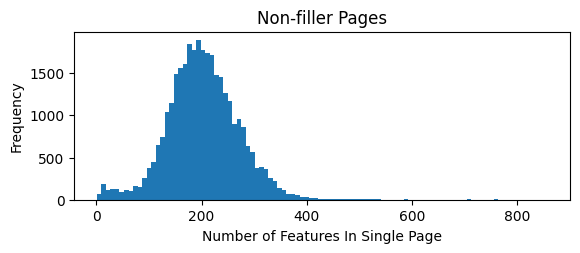

In [155]:
plot_features(nonfiller_feats, "Non-filler Pages")

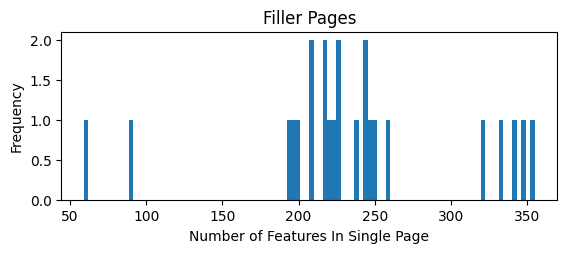

In [140]:
plot_features(filler_feats, "Filler Pages")

## 3. Crate training/validation split in `train_val_page_split.pkl`


Of all the non-filler pieces, we allocate 60% to training and 40% to validation. The same split is done for filler pages.

We save this data split in files named `train_val_page_split.pkl`.

For `train_val_page_split.pkl`, we save:

1. the original `feats` dictionary

2. a dictionary of similiar structure consisting of all training bscore matrices that are not `None`

3. a similiar dictionary for all validation bscore matrices that are not `None`.

4. the composer, piece and page number information


In [11]:
def all_none(l):
    return all(v is None for v in l)


def split_data(feats, train=0.6, seed=420):
    np.random.seed(seed)
    dirs = list(feats.keys())
    np.random.shuffle(dirs)
    split = int(len(dirs) * train)
    train_feats = {
        d: [p for p in feats[d] if p is not None]
        for d in dirs[0:split]
        if not all_none(feats[d])
    }
    val_feats = {
        d: [p for p in feats[d] if p is not None]
        for d in dirs[split:]
        if not all_none(feats[d])
    }
    return train_feats, val_feats

In [12]:
# def find_best_seed(n=10000):
#     res = []
#     for i in range(0, n):
#         train_feats, val_feats = split_data(feats, train=.5, seed=i)
#         train_filler_feats, val_filler_feats = split_data(filler_feats, train=.5, seed=i)
#         train_feats_num_pages = sum([len(train_feats[d]) for d in train_feats])
#         val_feats_num_pages = sum([len(val_feats[d]) for d in val_feats])
#         train_filler_feats_num_pages = sum([len(train_filler_feats[d]) for d in train_filler_feats])
#         val_filler_feats_num_pages = sum([len(val_filler_feats[d]) for d in val_filler_feats])
#         diff1 = abs(train_feats_num_pages-val_feats_num_pages)
#         diff2 = abs(train_filler_feats_num_pages-val_filler_feats_num_pages)
#         res.append((diff1+diff2, diff1, diff2, i))
#     res.sort()
#     for i in range(10):
#         print(f'Seed {res[i][3]} has {res[i][0]} differences in pages. {res[i][1]} for non-filler and {res[i][2]} for filler')

In [13]:
train_pages, val_pages = split_data(nonfiller_feats)
train_filler_pages, val_filler_pages = split_data(filler_feats)

In [14]:
save_to_pickle(
    [train_pages, val_pages, train_filler_pages, val_filler_pages],
    data_path / "train_val_page_split.pkl",
)

In [15]:
print(f"{sum([len(train_pages[d]) for d in train_pages])} pages in train_pages")
print(f"{sum([len(val_pages[d]) for d in val_pages])} pages in val_pages")
print(
    f"{sum([len(train_filler_pages[d]) for d in train_filler_pages])} pages in train_filler_pages"
)
print(
    f"{sum([len(val_filler_pages[d]) for d in val_filler_pages])} pages in val_filler_pages"
)

3478 pages in train_pages
2460 pages in val_pages
160 pages in train_filler_pages
99 pages in val_filler_pages


## 4. Sample filler pages to get `N_filler_train` and `N_filler_val`


For each filler page, we sample all length $L=16$ fragments with $50\%$ overlap. This dense sampling will augment our training and validation data.

We sample filler pages from `train_filler_pages` and `val_filler_pages` in the same manner.

We end up with `N_filler_train` and `N_filler_val` which represent tensors of shape $(1689, 62, 16)$ and $(1110, 62, 16)$ respectively.

This means that there are $1689$ and $1110$ training and validation fragments respectively. Every fragment is a bscore matrix of size $(62, 16)$.


In [16]:
def sample_filler(feats, L=16):
    res = []
    pages = [page[0] for dir in feats for page in feats[dir]]
    for page in pages:
        for i in range(0, page.shape[1] - L, L // 2):
            res.append(page[:, i : i + L])
    return np.array(res)

In [17]:
L = 16
N_filler_train = sample_filler(train_filler_pages, L)
N_filler_val = sample_filler(val_filler_pages, L)

In [18]:
print(f"{N_filler_train.shape[0]} training filler fragments with augmentation")
print(f"{N_filler_val.shape[0]} validation filler fragments with augmentation")

1689 training filler fragments with augmentation
1110 validation filler fragments with augmentation


## 5. Sample non-filler pages to get `N_train` and `N_val`


For the training data, we want to ensure we have an equal number of filler and non-filler pages. Thus, for every filler page in `N_filler_train`, we sample a random fragment from a random piece from the training partition `train_feats`. This ensures all pieces are represented equally.

The validation data is sampled in a similiar manner.

We end up with `N_train` and `N_val` which represent tensors of shape $(1689, 62, 16)$ and $(1110, 62, 16)$ respectively.

Notice this is the same shape of `N_filler_train` and `N_filler_val` respectively.


In [19]:
def sample_nonfiller(feats, filler, L=16):
    np.random.seed(42)
    res = []
    pieces = [feats[dir] for dir in feats]
    for _ in filler:
        length = 0
        while length < L:
            piece = pieces[np.random.randint(len(pieces))]
            page = piece[np.random.randint(len(piece))]
            length = page[0].shape[1]
        i = np.random.randint(length - L)
        res.append(page[0][:, i : i + L])
    return np.array(res)

In [20]:
N_train = sample_nonfiller(train_pages, N_filler_train, L)
N_val = sample_nonfiller(val_pages, N_filler_val, L)

In [21]:
print(f"shape of non-filler training data {N_train.shape}")
print(f"shape of non-filler validation data {N_val.shape}")

shape of non-filler training data (1689, 62, 16)
shape of non-filler validation data (1110, 62, 16)


## 6. Create `train_val_fragment_split.pkl` containing training/validation tensors


To construct `X_train`, we simply concatenate the `N_train` and `N_filler_train` tensors.

We create a tensor of `y` labels where $y=1$ represents a filler page and $y=0$ otherwise.

`X_val` and `Y_val` are created similiarly. We shuffle all these tensors.

We then save `X_train`, `Y_train`, `X_val`, `Y_val` in `train_val_fragment_split.pkl`


In [22]:
def make_labels(non_filler, filler):
    zeros = np.zeros(non_filler.shape[0], dtype=int)
    ones = np.ones(filler.shape[0], dtype=int)
    X = np.concatenate([non_filler, filler], axis=0)
    Y = np.concatenate([zeros, ones], axis=0)
    i = np.arange(Y.shape[0])
    np.random.seed(42)
    np.random.shuffle(i)
    return X[i, :, :], Y[i]

In [23]:
X_train, Y_train = make_labels(N_train, N_filler_train)
X_val, Y_val = make_labels(N_val, N_filler_val)

In [24]:
print(f"shape of X_train training data {X_train.shape}")
print(f"shape of Y_train training data {Y_train.shape}")
print(f"shape of X_val validation data {X_val.shape}")
print(f"shape of Y_val validation data {Y_val.shape}")

shape of X_train training data (3378, 62, 16)
shape of Y_train training data (3378,)
shape of X_val validation data (2220, 62, 16)
shape of Y_val validation data (2220,)


In [25]:
save_to_pickle(
    [X_train, Y_train, X_val, Y_val], data_path / "train_val_fragment_split.pkl"
)

Let's quickly visualize the bootleg scores for a couple filler and non-filler pages.


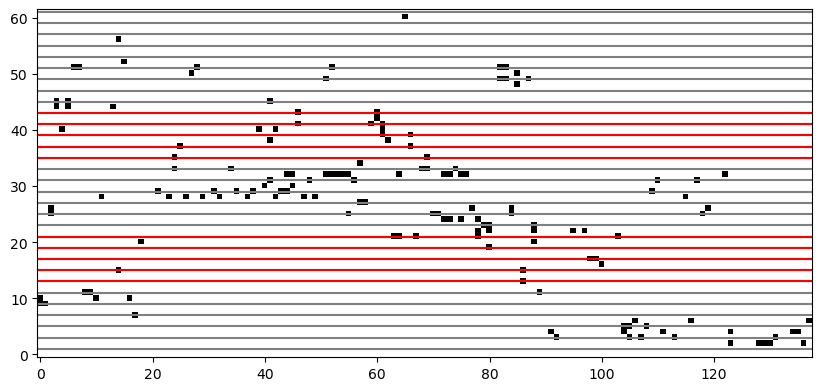

In [26]:
visualize_bootleg(nonignore_feats["filler/score_feat/Liszt/516478/"][0][0])

## 7. Create fragment classification training `train.csv` and `valid.csv`


`train.csv` and `valid.csv` are used for classifier training. Labels are needed for this step when we use transfer learning on the language model to correctly classify fragments as filler and non-filler.

Every line in the text file represents a single fragment. A fragment's bscore matrix is converted to a sequence of integer representations.


In [27]:
def generate_csv(x, y, outfile):
    with open(outfile, "w") as f:
        f.write("label,text\n")
        for i in range(x.shape[0]):
            ints = convert_binary_to_int(x[i, :, :])
            line = " ".join([str(i) for i in ints])
            chars = convert_line_to_char_sequence(line)
            f.write(f"{y[i]},{chars}\n")


generate_csv(X_train, Y_train, data_path / "finetune_fragment_train.csv")
generate_csv(X_val, Y_val, data_path / "finetune_fragment_valid.csv")

In [28]:
train_csv_lines = int(
    os.popen(f"wc -l filler/finetune_fragment_train.csv").read().split()[0]
)
print(f"There are {train_csv_lines-1} examples in finetune_fragment_train.csv")

There are 3378 examples in finetune_fragment_train.csv


In [29]:
valid_csv_lines = int(
    os.popen(f"wc -l filler/finetune_fragment_valid.csv").read().split()[0]
)
print(f"There are {valid_csv_lines-1} examples in finetune_fragment_valid.csv")

There are 2220 examples in finetune_fragment_valid.csv


In [30]:
!head -n 10 filler/finetune_fragment_train.csv

label,text
1,一一一丁一一一一 一乀一一一一一一 乀一一一一一一一 一一一一丁一一一 一一一丁一一一一 丠乀一一一一一一 一一一丐一一一一 一一丠一丠一一一 一丐一一丈一一一 一一一丠一一一一 一一一一一一一一 一一乀一一一一一 一丨一一一一一一 一一一一一一一一 一一一一一一一一 一一一一丠一一一
0,一一一一一丠一一 一一一一一丠一一 一一一一一亀一一 一一一一一乀一一 一一一一一一丈一 一一乂一一一丁一 一一一一一一丄一 一亀丐一一一丂一 一一一一一乀一一 一一一一一丐一一 一一一一一丄一一 一一一一亀一一一 一一一一丠一一一 一一一一丈一一一 一一一乀一一一一 一一一一丁一一一
0,一乀一一一丁一一 一一丁一亀一一一 一一丄一乀一一一 一一丐一一丂一一 一一亀一一丄一一 一一丐一一一一一 一一一丂一丁一一 一一丐一一一一一 一一丈一乀丄一一 一一丂一一一一一 一一丈一丐丂一一 一乀一一亀丁一一 一亀一一一丂一一 一一丈一一一一一 一丠一一亀一一一 一一丈一一一一一
1,一乀丁一一一一一 一一乀一一一丄一 一一丰一一一一一 一一乀一一一一一 一一丠一一一一一 一一乀一一一一一 亠一丠一一亀丈一 亀乀丁一一一一一 乀一一一一一一一 乀一一一一亀丄一 一一一一一亀一一 乐亀一一乐一一一 一一一一一丐一一 丠一一一一丐一一 一一丐一一一一一 一乐一一一一一一
0,一亀丂一一一一一 一一一一一亐一一 一丐一一一一一一 一一一一一両一一 亀一一一一一一一 一一一一亀丐一一 一亀丈一一乀一一 一乀丈一一亀一一 一一一一一一丁一 一一一一一乀一一 一一一一一亀一一 一一一一一丠一一 一乀丈一一亀一一 一亀丈一一乀一一 一一一一一亀一一 一一一一一丠一一
1,一丐丈一一一一一 一一丈一一一一一 一一丈一丈一一一 一一丈一一一一一 一一丈一一一一一 一丐一一一一一一 一丐丈一一一一一 一丈丈一一一一一 一丈丈一一一一一 一丐一一一一一一 乜一一一什七一一 一习一一一一一一 一一丨一一一一一 一一丐一一一一一 一一丠一一一一一 一一丐一一一一一
0,一一一一一丠一一 一一一一一丂一一 一一丈一一丁一一 一一一一亀一一一 一一一一乀一一一 一一丐一亀一一一 一一一一一丂一一 一一一一丠一一一 一一丂一一一一一 一一一一乀一一一 一一一一丐一一一 一一丄一丠一一一 一一一

In [31]:
!head -n 10 filler/finetune_fragment_valid.csv

label,text
1,一一丸一丄一一一 一一丄一一一一一 一一丂一一一一一 一一丄一一一一一 一一丂一一一一一 一丈一一一一一一 一一万一一一一一 一一上一一一一一 一一仧一一一一一 一亀丆一一一一一 一一万一一一一一 一一乘一一一一一 一一乊一一一一一 一一丄一一一一一 一一乨一亀一一一 一一乘一乀一一一
0,一一一一一乄丂一 一亠丈一一乄丂一 一一丕一乂丅一一 一一一一一丄丂一 一一一一一丄丂一 一一一一一丄丂一 丐丈一一一一一一 丐丈一一一一一一 一一一一一丁一一 丐丈一亀丨丁一一 丐丈一亀丨丁一一 丐丈一亀丨丁一一 丐丈一一一一一一 丐丈一一一一一一 丐丈一一一一一一 一一一一一丄一一
0,一一一一乀一一一 一丈一一丠一一一 一丐一一一一一一 一丠一一一丈一一 一一一一一丄一一 一乀一一一丂一一 一一一一一丁一一 一一丠乂丄一一一 一一且一乀丅一一 一一丁一一一一一 一乀一一一一一一 一乀一一一一一一 一乀一一亀丢一一 一丠一一一丛一一 一丠一一一一一一 一丐一一一一一一
0,丠丐一一亀一一一 一一丄一乀三一一 一一丠丄一丄一一 一一丁一一丈一一 一一丈丂乀丐一一 一一一一亀一一一 丠丐一一一丁一一 一一丂一亠丄一一 一一乀丈亀一一一 一亀一一一丁一一 一一丐丁亠丂一一 一一一一一丁一一 一丐丈一亀一一一 一一丈丄乐丈一一 一一丈丄一一一一 一一丈丄一一一一
0,一一丈一丂丁一一 一一一一一丄一一 一一一一一丈一一 一一一一一丄一一 一一亀丂习丐一一 一一一一乀一一一 一一一丁亐一一一 一一亀丂丐丁一一 一一乀丁丐丂一一 一一亠一丐丈一一 一一乀丁丐丂一一 一一丂丁亐一一一 一一亄一么一一一 一一丄丁予丄一一 一一乄一丨丄一一 一一丅一亀一一一
0,一丠一一一一一一 一丈一一丠丄丂一 一亠丄一一京丂一 一丂丠一一丈丄一 一乀丄一一亨丄一 一一丄一一丐丈一 一一丁一一一一一 一予丄一一亐上一 一丈丄一一亂乀一 一一丁一一一一一 一一专一乀丂一一 一丨丅一一一丢一 一一一一一丠丐一 一丢丁一一亡一一 一一一一一丂丁一 一一亄一一丢丁一
0,一一一一亀一一一 一乀丐一一七一一 一一亀一一丁一一 一一一一一丂一一 一一一一丠一一一 一一丄丁亀丐一一 一一一乀亀丐一一 一一一一亀一一一 一乀丐一一丁一一 一一一一一丂一一 一一亀一一丁一一 一一一一一丂一一 一一一